### Install and Import Dependencies

In [1]:
# Install the necessary packages
%pip install pandas
%pip install scipy
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install numpy
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\alena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\alena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\alena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\alena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\alena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\alena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 258.0/258.0 kB 5.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\alena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Importing packages

# For loading, processing, and displaying data
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
# For Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# For evaluating Classifier
from sklearn import metrics
# For Random Upsampling
from sklearn.utils import resample
# For SMOTE and Borderline SMOTE
from imblearn.over_sampling import SMOTE, RandomOverSampler

### Load Dataset

In [36]:
# Dataset downloaded from: https://archive.ics.uci.edu/dataset/266/seismic+bumps
# Load in the arff file
arff_file = arff.loadarff('data/seismic-bumps.arff')

# Convert to a pandas dataframe
data = pd.DataFrame(arff_file[0])

### Explore Dataset

In [5]:
# Get shape of dataframe: (rows, columns)
print("Shape of dataframe (rows, columns): ", data.shape)

Shape of dataframe (rows, columns):  (2584, 19)


In [6]:
# Peek into the dataframe
data.sample(5)

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
2168,b'b',b'a',b'W',39830.0,636.0,36.0,28.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1499,b'b',b'a',b'W',29500.0,794.0,119.0,106.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'1'
2522,b'b',b'a',b'W',36410.0,646.0,152.0,142.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'1'
1989,b'a',b'a',b'W',24300.0,508.0,2.0,11.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
763,b'a',b'b',b'W',42840.0,248.0,24.0,5.0,b'a',3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4000.0,2000.0,b'0'


ValueError: number of labels (1) does not match number of bars (2).

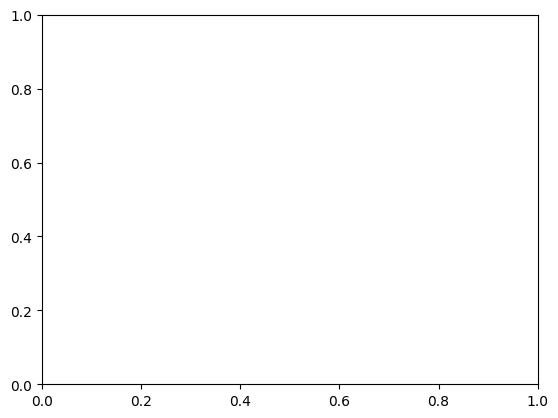

In [7]:
# Seaborn countplot documentation: https://seaborn.pydata.org/generated/seaborn.countplot.html
# Create a bar chart to plot counts of each class
ax = sns.countplot(x = data['class'], hue=data['class'])

# Add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

### Process/Split Dataset

In [37]:
# Get only the numerical data columns
input_cols = [i for i in range(data.shape[1]) if i not in ([0, 1, 2, 7, 18])]

# Split into input, X, and output, Y
X = data.iloc[:,input_cols]
Y = data.iloc[:,-1].astype(np.float32)

In [38]:
# Get the shape of each
print("Shape of X: ", X.shape)
print("Shape of Y: ", Y.shape)

# Peak into each part
display(X.head(5))
display(Y.head(5))

Shape of X:  (2584, 14)
Shape of Y:  (2584,)


,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy
0,15180.0,48.0,-72.0,-72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14720.0,33.0,-70.0,-79.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0
2,8050.0,30.0,-81.0,-78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28820.0,171.0,-23.0,40.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0
4,12640.0,57.0,-63.0,-52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: class, dtype: float32

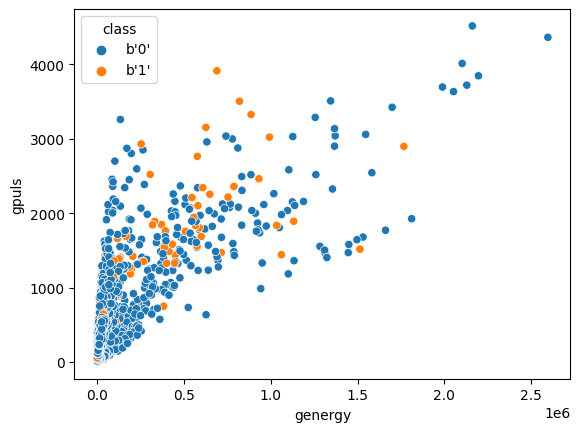

In [39]:
# Plot the some features of the input data with the majority and minority class
# Seaborn Scatterplot documentation: https://seaborn.pydata.org/generated/seaborn.scatterplot.html
ax = sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class')
plt.show()

In [40]:
# Split the data into the train and test set
# Scikitlearn train_test_split documentation: 
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

### Random Forest Scikit-learn

### Baseline Model

In [13]:
# Make the classifier. Use default values except the randomn_state sets the seed for the randomness in bootstrapping the data for each decision tree
# Sklearn Random Forest documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
classifier = RandomForestClassifier(random_state=0)

# FIt the classifier to the data
classifier.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

### Evaluation with Performance Metrics

In [14]:
# Running the test set through the model
# This function outputs the probability for each class
baseline_output = classifier.predict_proba(X_test)

# Peek into a few predicted output probabilities: (probability of class 0, probability of class 1)
print(baseline_output[:5])

# Grab the predicted probabilities for class 1 (We treat this as the positive, minority class)
y_class1_pred_prob = baseline_output[:, 1]

[[0.86 0.14]
 [0.98 0.02]
 [1.   0.  ]
 [0.78 0.22]
 [1.   0.  ]]


In [15]:
# Getting the False Positive and True Positive rates for later comparison
# Sklearn roc_curve documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
baseline_fpr, baseline_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob, pos_label=1) # pos_label specifies which class is the positive class

# Finding the AUC score for later comparison
# Sklearn auc documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
baseline_roc_auc = metrics.auc(baseline_fpr, baseline_tpr)

AttributeError: Line2D.set() got an unexpected keyword argument 'plot_chance_level'

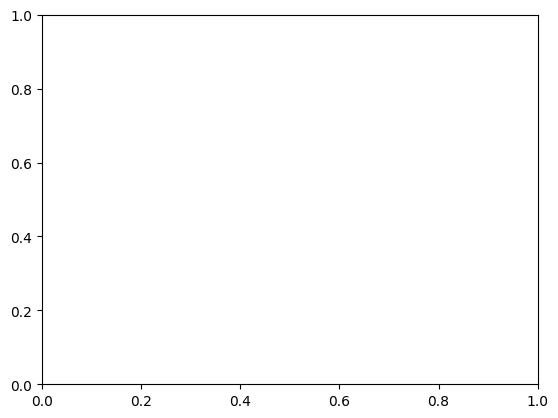

In [16]:
# Plotting the ROC curve
# Sklearn RocCurveDisplay documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html
baseline_display_roc = metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob, 
    pos_label=1, # Specify that class 1 is the positive class
    name='Baseline Classifier', 
    plot_chance_level=True # Plots the ROC curve for a random classifier
)

# Labeling and titling the plot
plt.title("ROC Curve for Baseline Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [17]:
# Get precision recall on the test set for later comparison
# Sklearn precision_recall_curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
baseline_precision, baseline_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob)

# Getting the AUC for later comparison
baseline_pr_auc = metrics.auc(baseline_recall, baseline_precision)

AttributeError: Line2D.set() got an unexpected keyword argument 'plot_chance_level'

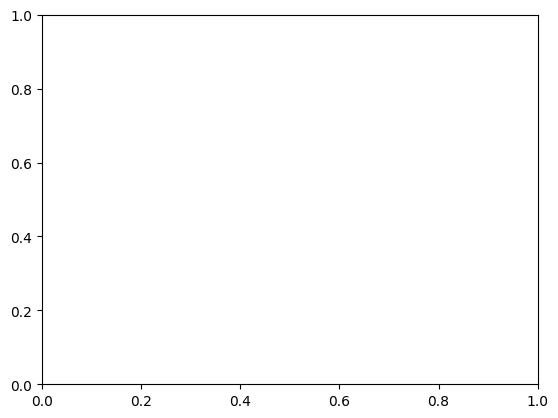

In [18]:
# Plotting the P-R Curve
# Sklearn PrecisionRecallDisplay documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html
baseline_display_pr = metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob,
    pos_label = 1,
    name = "Baseline Classifier",
    plot_chance_level=True # Plots the PR curve of a random classifier
)

# Labeling the plot
plt.title("Precision-Recall for Baseline Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Upsampling Techniques

### Random Upsampling

In [41]:
# X_randup, Y_randup = RandomOverSampler().fit_resample(X, Y)
# X_train_randup, X_test_randup, Y_train_randup, Y_test_randup = train_test_split(X_randup, Y_randup, test_size=0.3, random_state=0)
X_train_randup, Y_train_randup = RandomOverSampler().fit_resample(X_train, Y_train)

In [42]:
# Comparison of dataset sizes
counter = Counter(Y_train)
total = counter[0] + counter[1]
print('Before using Random Upsampling')
print('Number of data points in class 1:  ', counter[0])
print('Number of data points in class 2: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%\n')

counter = Counter(Y_train_randup)
total = counter[0] + counter[1]
print('After using Random Upsampling')
print('Number of data points in class 1:  ', counter[0])
print('Number of data points in class 2: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%')

Before using Random Upsampling
Number of data points in class 1:   1679
Number of data points in class 2:  129
Class 0:  92.87 %, Class 1:  7.13 %

After using Random Upsampling
Number of data points in class 1:   1688
Number of data points in class 2:  1691
Class 0:  49.96 %, Class 1:  50.04 %


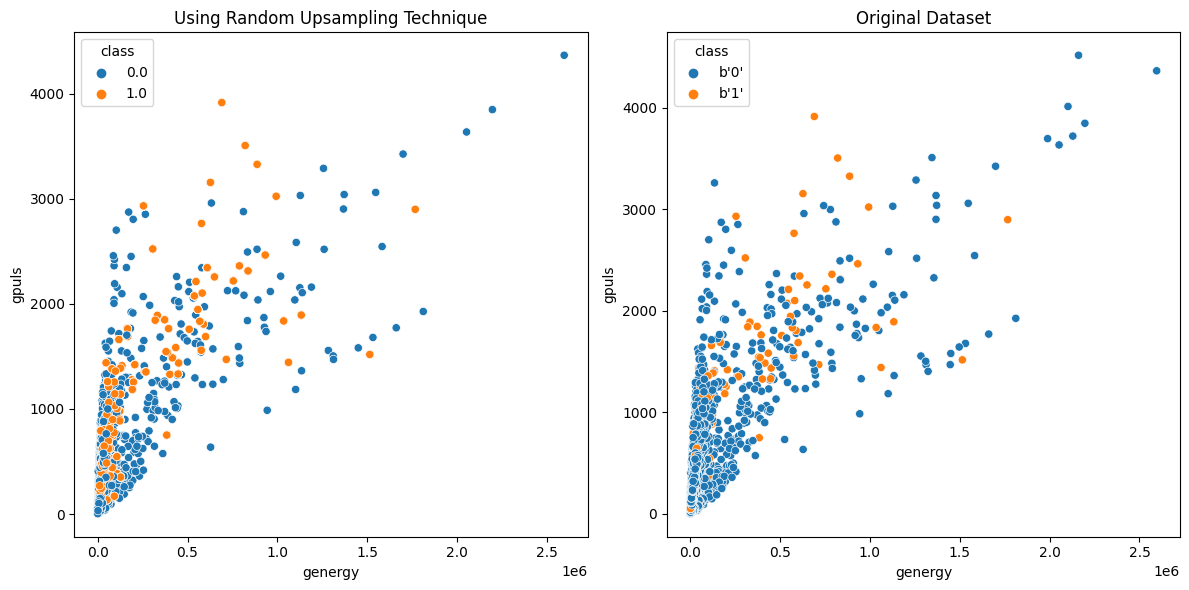

In [43]:
# Plot the new data
randup_df = pd.concat([X_train_randup, Y_train_randup], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=randup_df, x='genergy', y='gpuls', hue='class', ax=axes[0])
axes[0].set_title('Using Random Upsampling Technique')
sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class', ax=axes[1])
axes[1].set_title('Original Dataset')
plt.tight_layout()
plt.show()

In [44]:
# Building and fitting classifer to Random Upsampled data
randup_model = RandomForestClassifier(random_state=0)
randup_model.fit(X_train_randup, Y_train_randup)
randup_output = randup_model.predict_proba(X_test)
y_class1_pred_prob_randup = randup_output[:, 1]


In [45]:
# Get metrics: False Positive Rate, True Positive Rate, Precision, and Recall
randup_fpr, randup_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_randup, pos_label=1)
randup_roc_auc = metrics.auc(randup_fpr, randup_tpr)
randup_precision, randup_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_randup)
randup_pr_auc = metrics.auc(randup_recall, randup_precision)

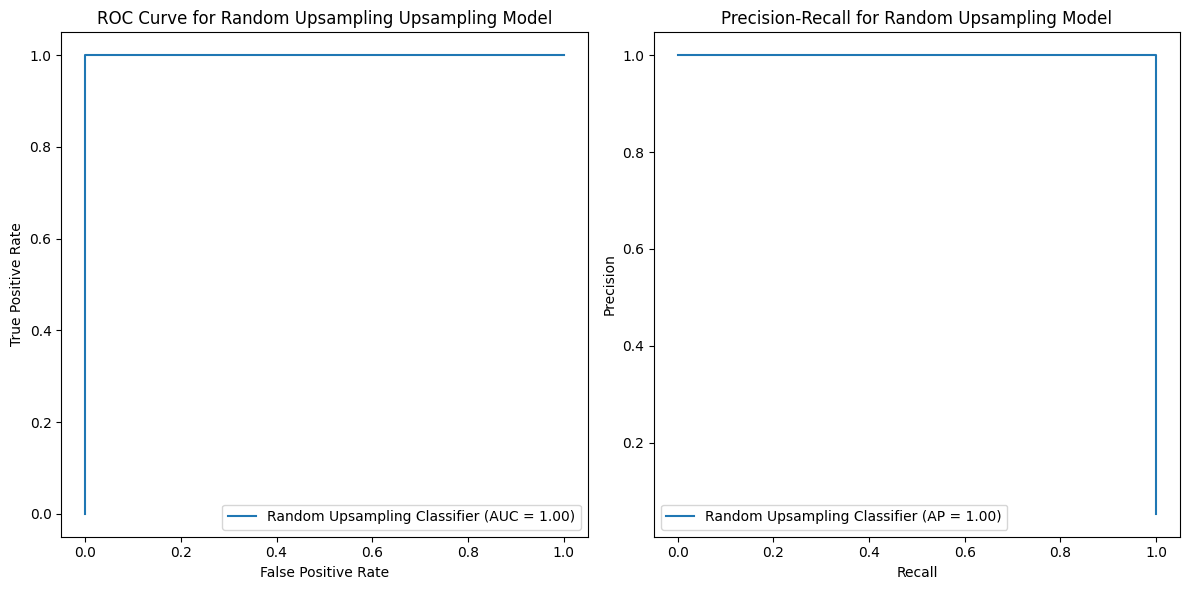

In [46]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_randup, 
    pos_label=1,
    name='Random Upsampling Classifier', 
    # plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for Random Upsampling Upsampling Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_randup,
    pos_label = 1,
    name = "Random Upsampling Classifier",
    # plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for Random Upsampling Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()

### SMOTE

In [217]:
# Applying SMOTE to the training data
# Imblearn SMOTE documentation: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
X_train_SMOTE, Y_train_SMOTE = SMOTE().fit_resample(X_train, Y_train)

In [218]:
# Comparison of dataset sizes
counter = Counter(Y_train)
total = counter[0] + counter[1]
print('Before using SMOTE')
print('Number of data points in class 1:  ', counter[0])
print('Number of data points in class 2: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%\n')

counter = Counter(Y_train_SMOTE)
total = counter[0] + counter[1]
print('After Using SMOTE')
print('Number of data points in class 1:  ', counter[0])
print('Number of data points in class 2: ', counter[1])
print('Class 0: ', round(counter[0] / total * 100, 2), '%, Class 1: ', round(counter[1] / total * 100, 2), '%')

Before using SMOTE
Number of data points in class 1:   1679
Number of data points in class 2:  129
Class 0:  92.87 %, Class 1:  7.13 %

After Using SMOTE
Number of data points in class 1:   1679
Number of data points in class 2:  1679
Class 0:  50.0 %, Class 1:  50.0 %


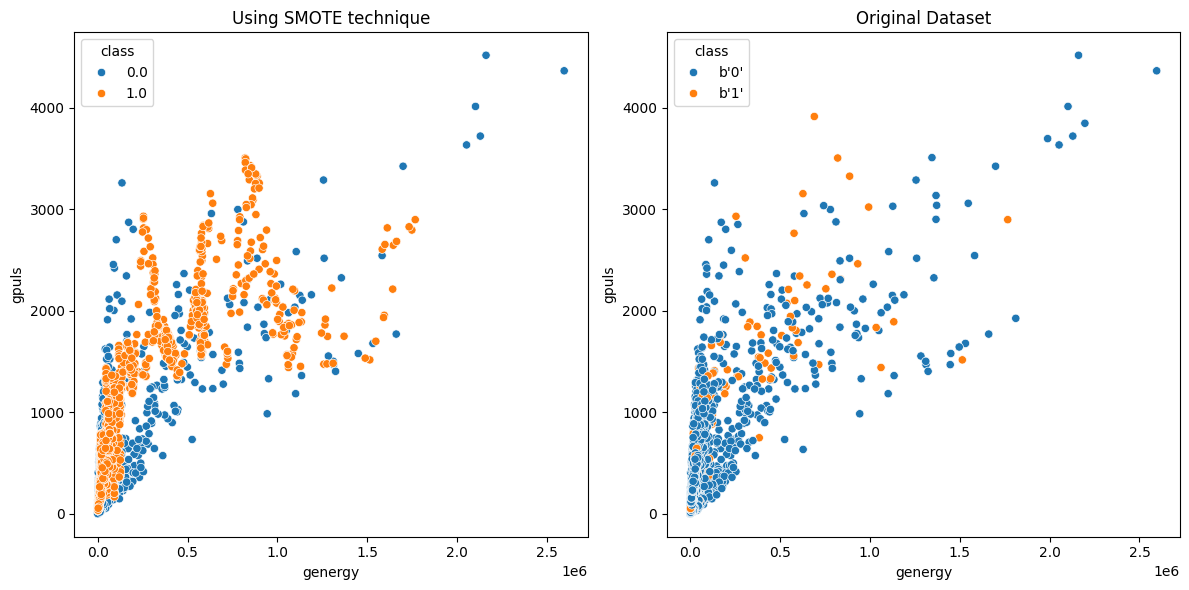

In [219]:
# Plot the new data
SMOTEDf = pd.concat([X_train_SMOTE, Y_train_SMOTE], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=SMOTEDf, x='genergy', y='gpuls', hue='class', ax=axes[0])
axes[0].set_title('Using SMOTE technique')
sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class', ax=axes[1])
axes[1].set_title('Original Dataset')
plt.tight_layout()
plt.show()

In [211]:
# I feel like we should embedded this code in like a drop down to save space because most of it is repeat stuff
# If the user wants to look at it again then sure let them, but at the end we should compare all ROC curves

# Building and fitting the classifier to the SMOTE data
SMOTE_model = RandomForestClassifier(random_state=0)
SMOTE_model.fit(X_train_SMOTE, Y_train_SMOTE)
output = SMOTE_model.predict_proba(X_test)
y_class1_pred_prob_SMOTE = output[:, 1]

In [212]:
# Get metrics: False Positive Rate, True Positive Rate, Precision, and Recall
SMOTE_fpr, SMOTE_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_SMOTE, pos_label=1)
SMOTE_roc_auc = metrics.auc(SMOTE_fpr, SMOTE_tpr)
SMOTE_precision, SMOTE_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_SMOTE)
SMOTE_pr_auc = metrics.auc(SMOTE_recall, SMOTE_precision)

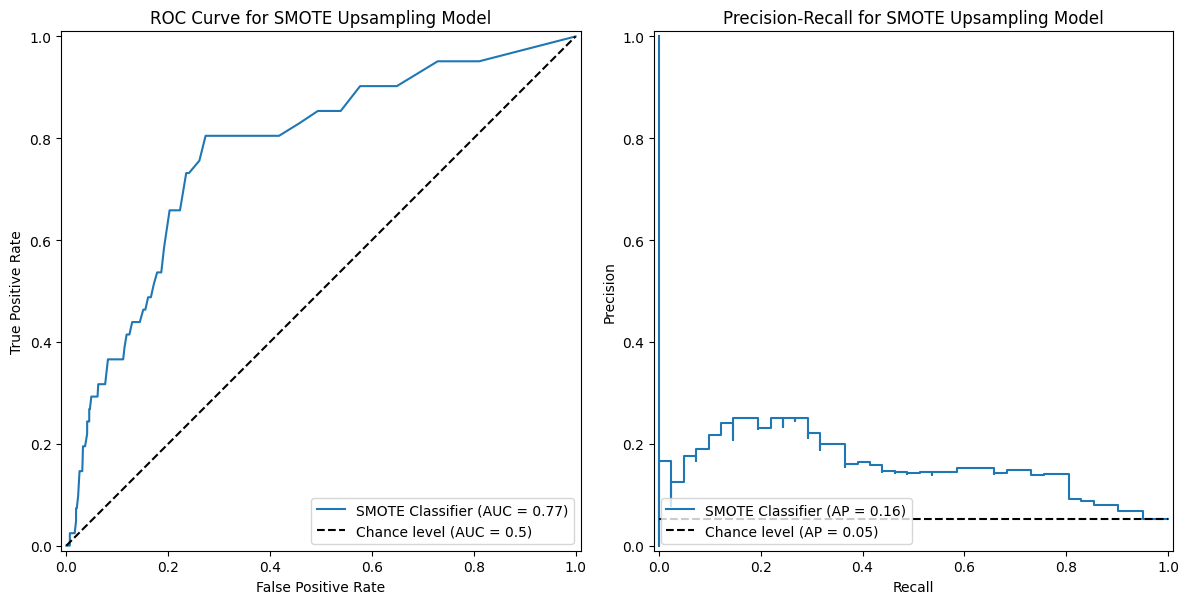

In [220]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_SMOTE, 
    pos_label=1,
    name='SMOTE Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for SMOTE Upsampling Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_SMOTE,
    pos_label = 1,
    name = "SMOTE Classifier",
    plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for SMOTE Upsampling Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()

### OPTIONAL: Borderline SMOTE

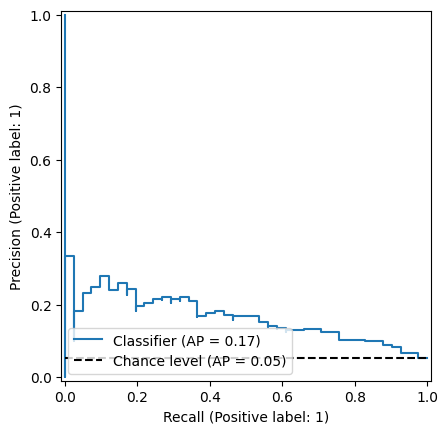

In [232]:
# x_smote, y_smote = SMOTE().fit_resample(X, Y)
# x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_smote, y_smote, test_size=0.3, random_state=0)
x_train_s, y_train_s = SMOTE().fit_resample(X_train, Y_train)

m = RandomForestClassifier(random_state=0)
m.fit(x_train_s, y_train_s)
y_pred_out = m.predict_proba(X_test)[:, 1]

metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_pred_out,
    pos_label=1,
    plot_chance_level=True
)

# Comparisons